# Conditional execution in DALI

DALI pipeline represents a data processing graph - the data is processed by one or more DALI operators, which are run unconditionally. Typically during training those operations are parametrized by random values - for example images may be rotated by random angle. To skip such operation user must ensure that the neutral parameter is provided - in the case of rotation it needs to be 0 degree angle of rotation.

Finding such configurations may not be practical and the operator provided with neutral value may still invoke some computation.

DALI allows `if`-based control flow in pipeline definition using the `@pipeline_def` decorator. The if and else branches will be executed only for the samples for which the appropriate condition applies.

Lets define a simple example, say we want to rotate the image with 25% probability by an angle in `[10, 30)` range and otherwise skip the rotation altogether. 

## Simple example

To enable the conditionals, we need to pass `enable_conditionals` flag to the `@pipeline_def` decorator.

Our pipeline does the following things:

1. Reads and decodes images.

2. Prepares a random predicate `do_rotate` that is used as `if` condition to decide whether we want to rotate the sample or not.

3. Prepares the random angle for rotation.

4. Applies the (random) rotation conditionally. We use 0-value fill to better highlight the rotation in the output.

5. Resizes the result to normalize them and returns the output of the pipeline.

In [1]:
from nvidia.dali import pipeline_def
from nvidia.dali.types import DALIDataType
from nvidia.dali import fn
from nvidia.dali import tensors

In [2]:
@pipeline_def(
    enable_conditionals=True, batch_size=4, num_threads=4, device_id=0, seed=42
)
def rotate_pipe():
    jpegs, _ = fn.readers.file(device="cpu", file_root="../data/images")
    images = fn.decoders.image(jpegs, device="mixed")
    do_rotate = fn.random.coin_flip(probability=0.25, dtype=DALIDataType.BOOL)
    angle = fn.random.uniform(range=(10, 30))

    if do_rotate:
        result = fn.rotate(images, angle=angle, fill_value=0)
    else:
        result = images

    resized = fn.resize(result, resize_x=400, resize_y=400)
    return resized

Now let's build and run the pipeline.

In [3]:
pipe = rotate_pipe()
pipe.build()

In [4]:
import matplotlib.pyplot as plt


def display(output):
    data_idx = 0
    fig, axes = plt.subplots(len(output) // 2, 2, figsize=(15, 15))
    if len(output) == 1:
        axes = [axes]
    for i, out in enumerate(output):
        img = out if isinstance(out, tensors.TensorCPU) else out.as_cpu()
        axes[i // 2, i % 2].imshow(img)
        axes[i // 2, i % 2].axis("off")

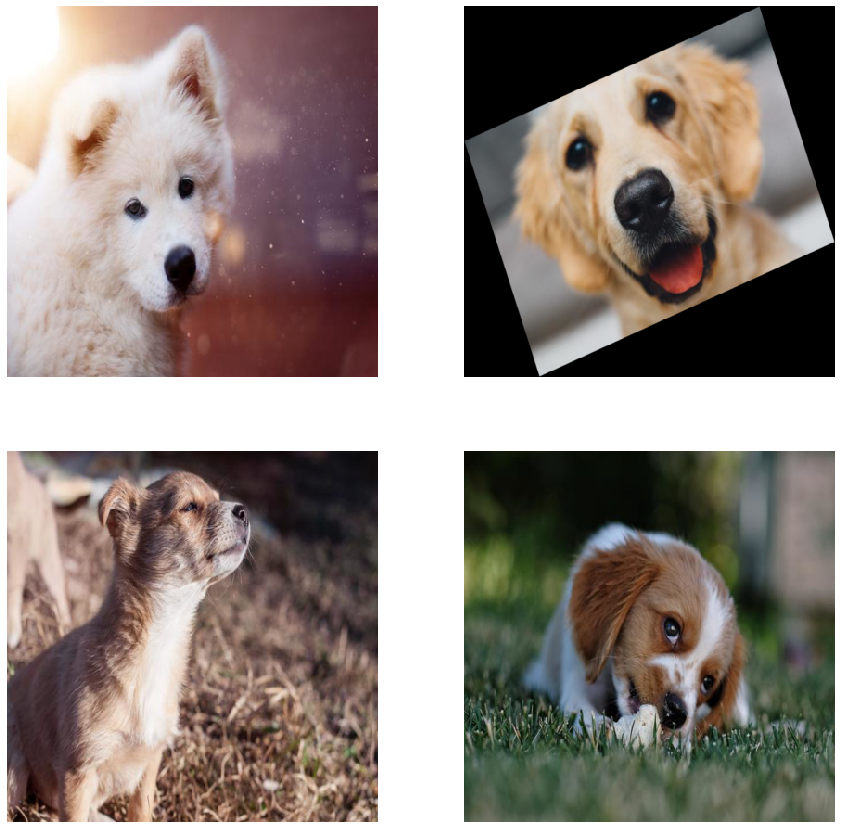

In [5]:
(output,) = pipe.run()
display(output)

As we can see, in the produced batch of 4 images, one of them was rotated by the random angle.

## Semantics
Although DALI operates on batches, the code that we wrote can be understood as if it operated on a single sample at a time.

### Requirements
There are several requirements that needs to be met when using the conditionals within DALI pipeline:

1. The `if` condition must be a DALI DataNode and the underlying data must be of type `BOOL` or other numerical type that can be evaluated to True or False in accordance with Python semantics.

The reason for this is the condition must be traceable during DALI pipeline run, and must represent a batch - each sample gets its associated condition value.

If the condition is some other Python value, the code is executed with regular Python semantics, only one branch is taken and no conditional operation is captured by DALI pipeline graph.

2. The `if` condition must be a batch of CPU data.

3. The "output" variables of the conditional must be defined in every branch. The output variables are those variables which are defined or modified within the scope of conditional branch and are used  after the conditional - in the example it's the `result` variable.

As an alternative, we could rewrite the conditional as:

```python
result = images
if do_rotate:
    result = fn.rotate(images, angle=angle, fill_value=0)
```

4. The output of every branch must be compatible - after the conditional, the corresponding outputs from all code paths in DALI graph are merged back into one batch, so the type, dimensionality and layout of data from every branch must match.

5. All output variables of such `if` statement are DALI DataNodes, something convertible to a DALI constant, or a nested structure of those.
For example NumPy arrays are automatically converted to a CPU constant node (a DALI Constant operator - it produces a batch where all samples are that array).

6. A nested structure is a Python data structure that is built out of dictionaries, lists and tuples - in this case they can contain DALI DataNodes or constants as their values. The structure must be matching between branches - for example we can use tuples of the same length or dictionaries that contain the same set of keys - the values may be different.

A simplest example is just one-level nesting of a dictionary:
```python 
if do_rotate:
    output_dict['result'] = fn.rotate(images, angle=angle, fill_value=0)
else:
    output_dict['result'] = images

result = output_dict['result']
```

If we used a different key names in the `if/else` branches, merging the structure won't be possible and would result in an error.

## Technical details

Under the hood DALI utilizes a fork of [TensorFlow's AutoGraph](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/index.md) to capture the `if` statements and rewrite them as functions which allows both branches to be traced. This means that `if` statement containing DALI DataNode as condition, both branches will be executed. We will see that later.

Functional style of writing pipelines is recommended, as defining results from conditionals as a means of side effects (for example assigning them as class members and relying on the values present in such local state) may not be correctly captured.

The captured code is translated into DALI processing graph. Each `if/else` pair is implemented by splitting the input batches (variables that were created outside of the `if` statement and are used within one of the branches as input to operator or referenced in assignement) into smaller ones, running the requested operations on subset of samples and merging the results into the output variable. 

### Equivalent pipeline

Below is the functionally equivalent code using the internal split and merge operators that realize the condition. Note that the split and merge do not introduce additional copies and allow us to execute an operator only on a part of a batch to which the condition applies.

In [6]:
@pipeline_def(batch_size=4, num_threads=4, device_id=0, seed=42)
def manual_rotation_pipe():
    jpegs, _ = fn.readers.file(device="cpu", file_root="../data/images")
    images = fn.decoders.image(jpegs, device="mixed")
    do_rotate = fn.random.coin_flip(probability=0.25, dtype=DALIDataType.BOOL)
    angle = fn.random.uniform(range=(10, 30))

    images_true_branch, images_false_branch = fn._conditional.split(
        images, predicate=do_rotate
    )
    angle_true_branch, angle_false_branch = fn._conditional.split(
        angle, predicate=do_rotate
    )

    result_true = fn.rotate(
        images_true_branch, angle=angle_true_branch, fill_value=0
    )
    result_false = images_false_branch

    result = fn._conditional.merge(
        result_true, result_false, predicate=do_rotate
    )

    resized = fn.resize(result, resize_x=400, resize_y=400)
    return resized

In [7]:
manual_pipe = manual_rotation_pipe()
manual_pipe.build()

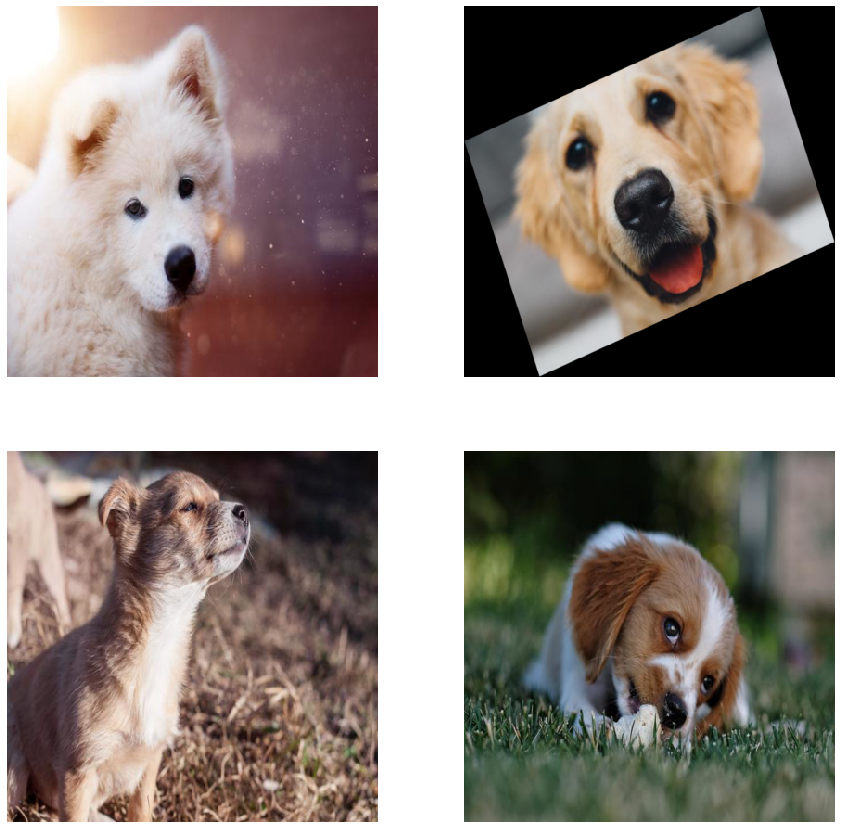

In [8]:
(output,) = manual_pipe.run()
display(output)

### Generators

Currently using the generator operators like random generators and readers will cause them to be executed as if they were run in the "global scope" even if they were put in the scope of a branch. Using them as an input to anything within the branch will take only a subset of the produced batch, but the whole batch will be produced regardless. 

### Functions

The tracing of `if` statements is not limited to the pipeline definition function. DALI and AutoGraph executed and trace all the code used to create pipeline, so it's possible to create helper functions containing conditionals.

In [9]:
def random_rotate(images):
    angle = fn.random.uniform(range=(10, 30))
    return fn.rotate(images, angle=angle, fill_value=0)


@pipeline_def(
    enable_conditionals=True, batch_size=4, num_threads=4, device_id=0, seed=42
)
def rotate_with_helper_pipe():
    jpegs, _ = fn.readers.file(device="cpu", file_root="../data/images")
    images = fn.decoders.image(jpegs, device="mixed")
    do_rotate = fn.random.coin_flip(probability=0.25, dtype=DALIDataType.BOOL)

    if do_rotate:
        result = random_rotate(images)
    else:
        result = images

    resized = fn.resize(result, resize_x=400, resize_y=400)
    return resized

In [10]:
helper_pipe = rotate_with_helper_pipe()
helper_pipe.build()

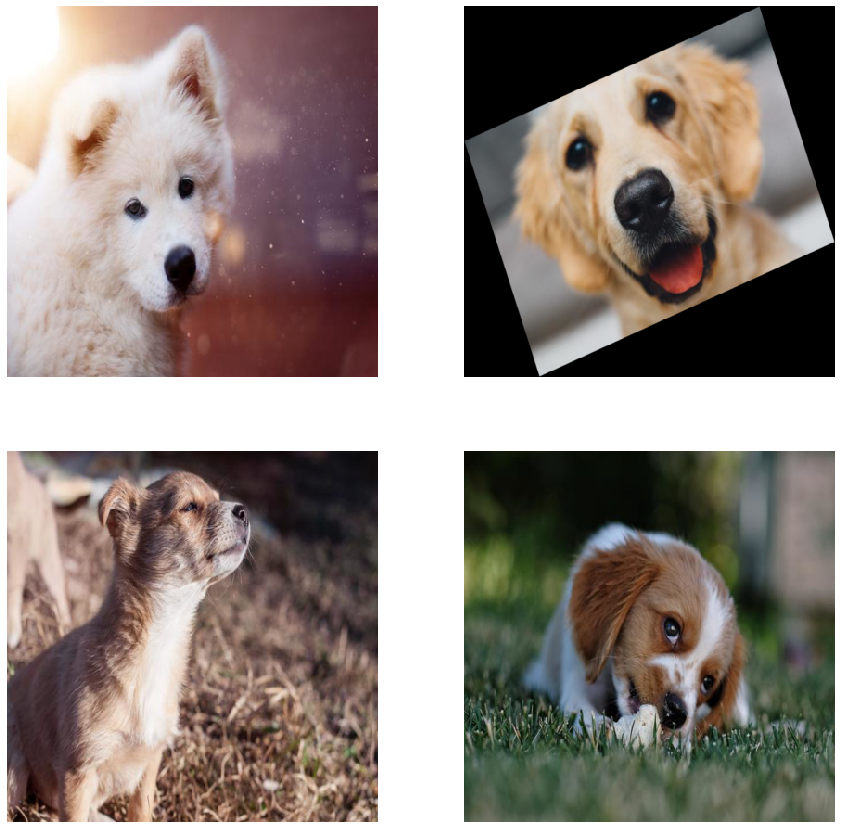

In [11]:
(output,) = helper_pipe.run()
display(output)

### Python statements and tracing
It is important to remember, that only `if` statements that contain DataNode within condition work as conditionals for DALI operations. If we replaced the `do_rotate` with a `random.choice([True, False])` statement, that value would be calculated once during tracing, and only one of the branches would be known to the pipeline graph. When DataNode is detected in condition, it allows the `if` statement to be transformed by AutoGraph to capture both branches and trace the code within them. We can observe that fact by adding some print statements and checking which would show when the pipeline is constructed.

In [12]:
import random


@pipeline_def(
    enable_conditionals=True, batch_size=4, num_threads=4, device_id=0, seed=42
)
def pipe_with_dali_conditional():
    jpegs, _ = fn.readers.file(device="cpu", file_root="../data/images")
    images = fn.decoders.image(jpegs, device="mixed")
    dali_random_value = fn.random.coin_flip(dtype=DALIDataType.BOOL)

    if dali_random_value:
        print("Tracing True branch")
        result = images + 10
    else:
        print("Tracing False branch")
        result = images
    return result


@pipeline_def(
    enable_conditionals=True, batch_size=4, num_threads=4, device_id=0, seed=42
)
def pipe_with_python_conditional():
    jpegs, _ = fn.readers.file(device="cpu", file_root="../data/images")
    images = fn.decoders.image(jpegs, device="mixed")
    dali_random_value = fn.random.coin_flip(dtype=DALIDataType.BOOL)

    if random.choice([True, False]):
        print("Tracing True branch")
        result = images + 10
    else:
        print("Tracing False branch")
        result = images
    return result

In [13]:
pipe_with_dali_conditional()

Tracing True branch
Tracing False branch


In [14]:
pipe_with_python_conditional()

Tracing True branch


As we can see, when the condition is DataNode, we correctly traced both branches, and our samples would be processed according to the contents of the `dali_random_value` for corresponding sample_idx. For the `pipe_with_python_conditional` we traced only one of the branches, as the value was obtained onces during tracing and is seen as a constant.